In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import random

In [2]:
import scipy.io
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)

C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)

B = scipy.io.loadmat('traffic.mat')["traffic"]

l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)


In [3]:
n_V = np.shape(B)[0] # number of nodes
n_E = np.shape(B)[1] # number of edges

In [4]:
G = nx.DiGraph()

for e in range(n_E):
    G.add_edge(list(B[:,e]).index(1)+1, list(B[:,e]).index(-1)+1, weight=l[e], capacity = C[e], flow = f[e])

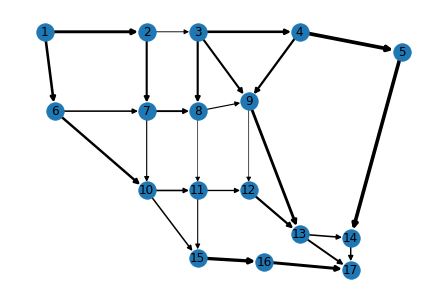

In [5]:
pos = {1:[0,6],
       2:[2,6],
       3:[3,6], 
       4:[5,6], 
       5:[7,5.5], 
       6:[0.2,4], 
       7:[2,4], 
       8:[3,4], 
       9:[4,4.25], 
       10:[2,2],
       11:[3,2],
       12:[4,2],
       13:[5,0.9],
       14:[6,0.8],
       15:[3,0.3],
       16:[4.3,0.2],
       17:[6,0]}

weights = [20*G[u][v]['weight'] for u,v in G.edges()] # get travel time to show it in graph

# more travel time is shown with bolder lines 
nx.draw(G,pos = pos, width = 500*weights, with_labels=True) 
# plt.savefig("31.eps",format='eps')

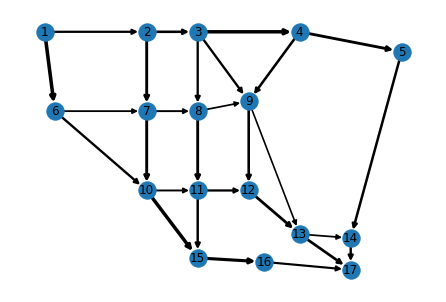

In [6]:
weights = [G[u][v]['capacity']/(C.mean()/2.5) for u,v in G.edges()]  # get capacity to show it in graph

# more capacity is shown with bolder lines 
nx.draw(G,pos = pos, width = weights, with_labels=True)
# plt.savefig("32.eps",format='eps')

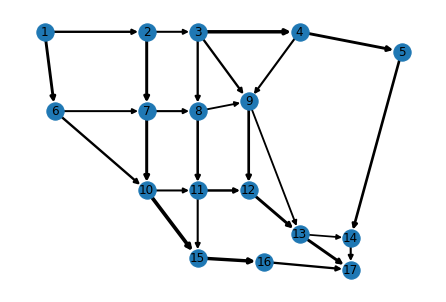

In [7]:
weights = [G[u][v]['flow']/(f.mean()/2.5) for u,v in G.edges()] # get flow to show it in graph

# more flow is shown with bolder lines 
nx.draw(G,pos = pos, width = weights, with_labels=True)
# plt.savefig("33.eps",format='eps')

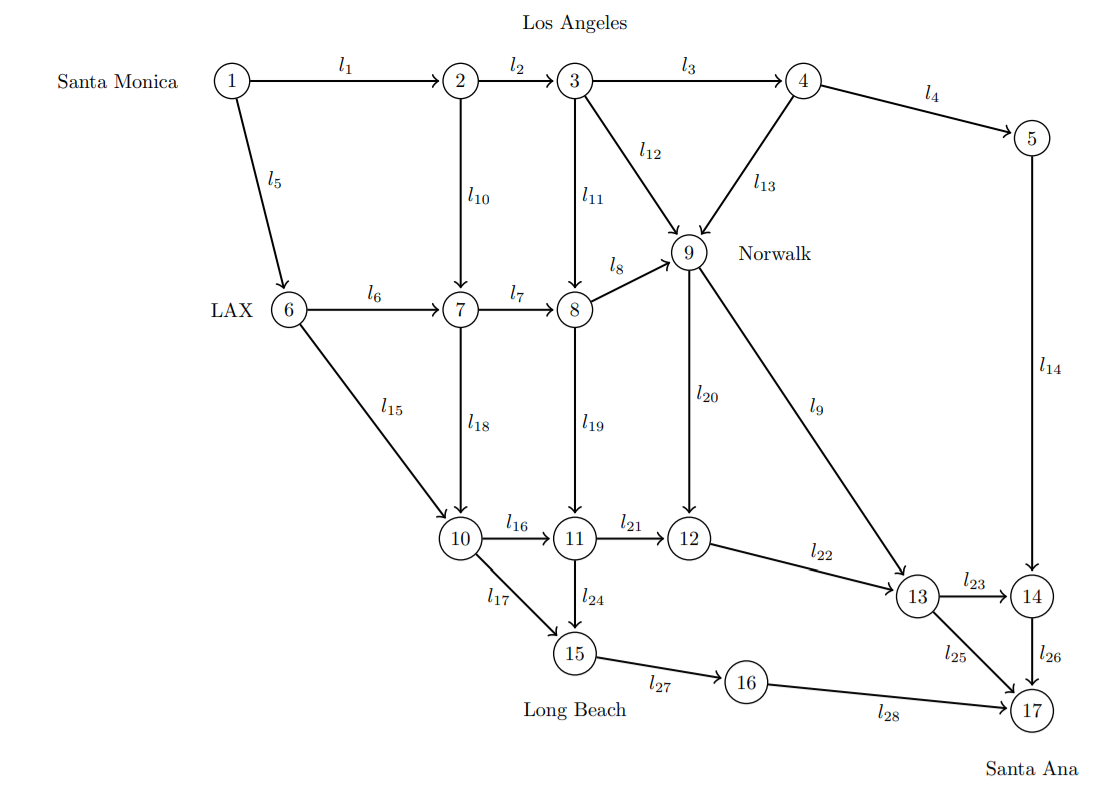

## (a) Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In [8]:
print(nx.shortest_path(G,1,17, weight = 'weight'))
print(nx.shortest_path_length(G,1,17, weight="weight"))

[1, 2, 3, 9, 13, 17]
0.532996


## (b) Find the maximum flow between node 1 and 17.

In [9]:
nx.maximum_flow(G,1,17)

(22448,
 {1: {2: 8741, 6: 13707},
  2: {3: 8741, 7: 0},
  3: {4: 0, 8: 0, 9: 8741},
  4: {5: 0, 9: 0},
  5: {14: 0},
  6: {7: 4624, 10: 9083},
  7: {8: 4624, 10: 0},
  8: {9: 4624, 11: 0},
  9: {13: 6297, 12: 7068},
  13: {14: 3835, 17: 10355},
  14: {17: 3835},
  10: {11: 825, 15: 8258},
  11: {12: 825, 15: 0},
  15: {16: 8258},
  12: {13: 7893},
  17: {},
  16: {17: 8258}})

## (c) Given the flow vector in flow.mat, compute the external inflow ν satisfying $Bf = \nu$.

In [10]:
v = B@f
v1 = v[0]
v17 = -v1
v

array([ 16806,   8570,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

In [11]:
v_ = np.zeros(n_V)
v_[0] = v1
v_[16] = v17
v_

array([ 16806.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0., -16806.])

## (d) Find the social optimum $f^∗$ with respect to the delays on the different links $d_e(f_e)$. For this, minimize the cost function
$$
\sum_{e\in\varepsilon}f_ed_e(f_e) = \sum_{e\in\varepsilon} \left(\frac{l_eC_e}{1-f_e/C_e}-l_eC_e \right)
$$

In [12]:
import cvxpy as cp

In [13]:
# delay and total delay functions
def delay(f):
    return f*l/(1-f/C)
def tdelay(f):
    return sum(delay(f))

In [14]:
f_var = cp.Variable(n_E)
# objective and constraints
SO_obje = cp.Minimize(cp.sum(cp.multiply(cp.multiply(l,C), cp.inv_pos(1-(cp.multiply(f_var, cp.inv_pos(C)))))-cp.multiply(l,C)))
SO_cons = [B@f_var==v_, f_var>=0, f_var<=C]
prob = cp.Problem(SO_obje,SO_cons)
SO_cost = prob.solve()
SO_flow = f_var.value
np.set_printoptions(suppress=True) # change scientific notation for printing

print("Cost: ", SO_cost)
print("Flow: ", np.round(SO_flow, 3))

Cost:  25943.62261121288
Flow:  [ 6642.199  6058.938  3132.328  3132.326 10163.801  4638.317  3006.341
  2542.635  3131.544   583.261     0.015  2926.596     0.002  3132.326
  5525.484  2854.273  4886.449  2215.237   463.721  2337.688  3317.991
  5655.679  2373.107     0.002  6414.116  5505.433  4886.451  4886.451]


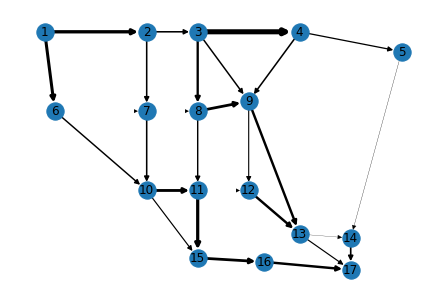

In [15]:
weights = [x/2000 for x in (SO_flow)]  # here flow is divided by a number in order properly show the boldness in the graph

nx.draw(G,pos = pos, width = weights, with_labels=True)
# plt.savefig("3d.eps",format='eps')

## (e) Find the Wardrop equilibrium f^(0) . For this, use the cost function

$$
\sum_{e\in\varepsilon}\int^{f_e}_0  d_e(s)ds
$$

First definite integral of the function is found by;

$$
\sum_{e\in\mathcal{E}}\int^{f_e}_0d_e(s)ds=-l_eC_e\left(ln(C_e-s)\right)\Big|_0^f=\sum_{e\in\mathcal{E}} l_eC_e\left(ln(C_e) - ln(C_e-f_e) \right)
$$

With the help of CVXPY library 
$$
min\sum_{e\in\mathcal{E}} l_eC_e\left(ln(C_e) - ln(C_e-f^{(0)}) \right)
$$

In [16]:
f_var = cp.Variable(n_E)

UO_obje = cp.Minimize(cp.sum(cp.multiply(cp.multiply(l,
                                                        C),
                                            cp.log(C)-cp.log(C-f_var))))



UO_cons = [B@f_var==v_, f_var>=0, f_var<=C]
prob = cp.Problem(UO_obje,UO_cons)

prob.solve()
UO_flow = f_var.value
UO_total_delay = tdelay(UO_flow)

print("Total delay: ", UO_total_delay)
print("Flow: ", np.round(UO_flow, 3))

Total delay:  26292.96330601271
Flow:  [ 6715.649  6715.645  2367.409  2367.409 10090.351  4645.394  2803.846
  2283.557  3418.48      0.005   176.816  4171.42      0.     2367.409
  5444.956  2353.173  4933.337  1841.554   697.104  3036.497  3050.276
  6086.773  2586.513     0.001  6918.741  4953.922  4933.337  4933.337]


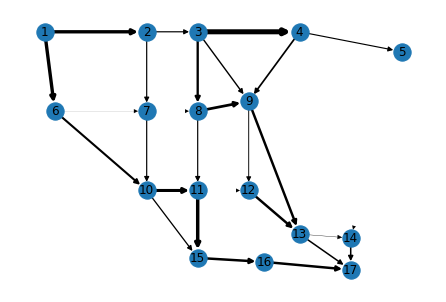

In [17]:
weights = [x/2000 for x in (UO_flow)]

nx.draw(G,pos = pos, width = weights, with_labels=True)
# plt.savefig("3e.eps",format='eps')

## (e) Introduce tolls, such that the toll on link e is $\omega_e = f^*_ed'_e(f^*_e)$, where $f^*_e$ is the flow at the system optimum. Now the delay on link e is given by $d_e(f_e)+\omega_e$. compute the new Wardrop equilibrium $f^*_e$. What do you observe?

First derivative of delay function is found
$$
d'_e(f^*_e)=\frac{C_el_e}{(f^*_e-C_e)^2} 
$$
Then
$$
\omega_e = f^*_ed'_e(f^*_e)=\frac{f^*_eC_el_e}{(f^*_e-C_e)^2} 
$$

With these on hand we can find new problem to optimize with tolls:

$$    min\sum_{e\in\mathcal{E}}\left[  l_eC_e\left(ln(C_e) - ln(C_e-f^{(\omega)}_e) \right)+ f^{(\omega)}_e\omega_e\right]
$$

In [18]:
omega = SO_flow*C*l/(SO_flow-C)**2

In [19]:
f_var = cp.Variable(n_E)

UO_toll_obje = cp.Minimize(cp.sum(cp.multiply(cp.multiply(l,C),
                                        cp.log(C)-cp.log(C-f_var)) 
                                  + cp.multiply(f_var,omega)))



UO_toll_cons = [B@f_var==v_, f_var>=0, f_var<=C]
prob = cp.Problem(UO_toll_obje,UO_toll_cons)

UO_toll_cost = prob.solve()
UO_toll_flow = f_var.value

prob.solve()
UO_toll_flow = f_var.value
UO_toll_total_delay = tdelay(UO_toll_flow)

print("Total delay: ", UO_toll_total_delay)
print("Flow: ", UO_toll_flow)

Total delay:  25943.622350312617
Flow:  [ 6642.97446922  6059.07643864  3132.47228908  3132.47200297
 10163.02541378  4638.25874653  3006.32655066  2542.33807888
  3131.48796558   583.89803058     0.00114255  2926.60300701
     0.00028611  3132.47200297  5524.76666724  2854.22629974
  4886.37059396  2215.83022646   463.98961434  2337.45340641
  3318.21555075  5655.66895717  2373.03536544     0.00036332
  6414.1215573   5505.50736841  4886.37095728  4886.37095728]


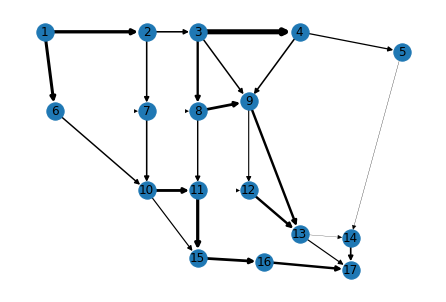

In [20]:
weights = [x/2000 for x in (UO_toll_flow)]

nx.draw(G,pos = pos, width = weights, with_labels=True)
plt.savefig("3e1.eps",format='eps')

In [21]:
def poa(uo, so, digits = 3):
    return round(uo/so, digits)

In [22]:
poa(UO_total_delay, SO_cost,4)

1.0135

In [23]:
poa(UO_toll_total_delay,SO_cost, 4)

1.0

## (f) Instead of the total delay, let the cost be the total additional delay compared to the total delay in free flow be given by $$c_e(f_e)=f_e(d_e(f_e)-l_e)$$ subject to the flow constraints. Compute the system optimum $f^*$ for the costs above. Construct tolls $\omega^*_e, e\in\varepsilon$  that the new Wardrop equilibrium with the constructed tolls $f^{\omega^*}$ coincides with $f^*$. Compute the new Wardrop equilibrium with the constructed tolls $f^{\omega^*}$ to verify your result.

$$
    c_e(f_e) =
    \sum_{e\in\mathcal{E}}f_e(d_e(f_e)-l_e) = \sum_{e\in\mathcal{E}} \left(\frac{l_eC_e}{1-f_e/C_e}-l_eC_e-l_ef_e \right)
$$

First derivative of delay function is found
$$
d'_e(f^*_e)=\frac{C_el_e}{(f^*_e-C_e)^2} 
$$
Then
$$
\omega^*_e = f^*_ed'_e(f^*_e)=\frac{f^*_eC_el_e}{(f^*_e-C_e)^2} 
$$




$$
    \sum_{e\in\mathcal{E}}\int^{f_e}_0  (d_e(s) - l_e)ds +f_e\omega^*_e=
    \sum_{e\in\mathcal{E}}-l_e C_e\left(ln(C_e-s)\right)-l_es\Big|_0^f +f_e\omega^*_e=
    \sum_{e\in\mathcal{E}}\left[ l_eC_e\left(ln(C_e) - ln(C_e-f_e)\right) -l_ef_e +f_e\omega^*_e \right]
$$

In [24]:
def delay_(f):
    return f*l/(1-f/C) - l*f
def tdelay_(f):
    return sum(delay_(f))

In [25]:
f_var = cp.Variable(n_E)
SO_obje_ = cp.Minimize(cp.sum(cp.multiply(cp.multiply(l,C), cp.inv_pos(1-(cp.multiply(f_var, cp.inv_pos(C)))))
- cp.multiply(l,C) 
- cp.multiply(f_var, l)))
SO_cons_ = [B@f_var==v_, f_var>=0, f_var<=C]
prob = cp.Problem(SO_obje_,SO_cons_)

ppp = prob.solve()
SO_flow_ = f_var.value
SO_cost_ = tdelay_(SO_flow_)

print("Cost:      ", SO_cost_)
print("Flow: ", np.round(SO_flow_, 3))


omega_ = SO_flow_*C*l/(SO_flow_-C)**2

f_var = cp.Variable(n_E)


UO_toll_obje_ = cp.Minimize(cp.sum(cp.multiply(l, 
                                               cp.multiply(C,cp.log(C))
                                               -cp.multiply(C,cp.log(C-f_var))
                                               -f_var)
                                               +cp.multiply(f_var,omega_)))


UO_toll_cons_ = [B@f_var==v_, f_var>=0, f_var<=C]
prob = cp.Problem(UO_toll_obje_,UO_toll_cons_)

prob.solve()
UO_toll_flow_ = f_var.value
UO_toll_total_delay_ = tdelay_(UO_toll_flow_)

print("Total delay: ", UO_toll_total_delay_)
print("Flow: ", UO_toll_flow_)

Cost:       15095.513524607866
Flow:  [ 6653.297  5774.662  3419.717  3419.711 10152.703  4642.78   3105.84
  2662.185  3009.079   878.634     0.007  2354.938     0.006  3419.711
  5509.923  3043.693  4881.805  2415.575   443.663  2008.05   3487.353
  5495.403  2203.778     0.002  6300.704  5623.489  4881.807  4881.807]
Total delay:  15095.513256019116
Flow:  [ 6653.13186254  5775.41861223  3419.48015483  3419.47940279
 10152.86809007  4642.42326506  3105.49323142  2661.73318847
  3009.16879616   877.71325031     0.00094138  2355.93751602
     0.00075204  3419.47940279  5510.44482501  3043.37621851
  4881.71189044  2414.64328395   443.76098434  2008.50266036
  3487.13690893  5495.6395693   2204.0696741      0.00029391
  6300.73869136  5623.54907689  4881.71218436  4881.71218436]


In [26]:
poa(UO_toll_total_delay_, SO_cost_,5)

1.0